In [1]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt


Mounted at /content/drive


In [2]:
import os
import shutil
import glob

# Define your base data directory
# This should be the folder where your images and masks are currently together
DATA_DIR = "/content/drive/MyDrive/Colab_Projects/Geospatial_AI_Project/raw_data/train"
RAW_DATA_DIR="/content/drive/MyDrive/Colab_Projects/Geospatial_AI_Project/raw_data"
GOOGLE_DRIVE_PROJECT_ROOT="/content/drive/MyDrive/Colab_Projects/Geospatial_AI_Project"
MODEL_SAVE_DIR = os.path.join(GOOGLE_DRIVE_PROJECT_ROOT, 'geospatial_cnn_model_tf')

# Define the new folders for images and masks
IMAGES_DIR = os.path.join(DATA_DIR, "images")
MASKS_DIR = os.path.join(DATA_DIR, "masks")

# Create the new directories
os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)

# Get all files in the directory
all_files = os.listdir(DATA_DIR)

print(f"Separating files in '{DATA_DIR}'...")

# Iterate through the files and move them
for f in all_files:
    file_path = os.path.join(DATA_DIR, f)
    if f.endswith("_sat.jpg"):
        # This is an image file, move it to the images folder
        shutil.move(file_path, os.path.join(IMAGES_DIR, f))
    elif f.endswith("_mask.png"):
        # This is a mask file, move it to the masks folder
        shutil.move(file_path, os.path.join(MASKS_DIR, f))
print("File separation complete.")

# Verify the new folder contents
print(f"\nImages folder contents: {len(os.listdir(IMAGES_DIR))} files")
print(f"Masks folder contents: {len(os.listdir(MASKS_DIR))} files")


Separating files in '/content/drive/MyDrive/Colab_Projects/Geospatial_AI_Project/raw_data/train'...
File separation complete.

Images folder contents: 800 files
Masks folder contents: 800 files


In [3]:
# Colab Cell 3: Data Preprocessing & DataLoader
# Purpose: This cell prepares the images and masks into a format for model training.

from PIL import Image
from tqdm.notebook import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# --- Define Global Configuration for Dataset ---
IMG_SIZE = (256, 256)
NUM_CLASSES = 7
VAL_SPLIT_RATIO = 0.2

# ✅ Class Color Mapping (from your code)
CLASS_COLORS = {
    0: (0, 0, 0), 1: (0, 255, 255), 2: (255, 255, 0), 3: (255, 0, 255),
    4: (0, 255, 0), 5: (0, 0, 255), 6: (255, 255, 255),
}
COLOR_TO_CLASS = {v: k for k, v in CLASS_COLORS.items()}

# ✅ Image/Mask Loader Functions (Modified)
def rgb_to_class(mask):
    mask = np.array(mask)
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
    for rgb, cls in COLOR_TO_CLASS.items():
        match = np.all(mask == rgb, axis=-1)
        class_mask[match] = cls
    return class_mask

def load_image_and_mask(file_path):
    file_path_str = file_path.numpy().decode("utf-8")

    # Path to the mask is now in a separate 'masks' folder
    mask_path = file_path_str.replace("images", "masks").replace("_sat.jpg", "_mask.png")

    image = Image.open(file_path_str).convert("RGB").resize(IMG_SIZE)
    mask = Image.open(mask_path).convert("RGB").resize(IMG_SIZE)

    mask = rgb_to_class(mask)
    image = np.array(image) / 255.0
    mask = tf.one_hot(mask, depth=NUM_CLASSES)

    return image.astype(np.float32), mask.numpy().astype(np.float32)

def tf_wrapper(file_path):
    image, mask = tf.py_function(load_image_and_mask, [file_path], [tf.float32, tf.float32])
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], NUM_CLASSES])
    return image, mask
# --- Get List of Image and Mask Paths (Modified) ---
images_dir = os.path.join(RAW_DATA_DIR, 'train', 'images')
masks_dir = os.path.join(RAW_DATA_DIR, 'train', 'masks')
all_image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(".jpg")])
all_mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith(".png")])

train_files, val_files = train_test_split(all_image_files, test_size=VAL_SPLIT_RATIO, random_state=42)
print(f"\nTotal dataset size: {len(all_image_files)}")
print(f"Training set size: {len(train_files)}")
print(f"Validation set size: {len(val_files)}")

BATCH_SIZE = 8
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE).shuffle(50).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
val_dataset = val_dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print("\nData preprocessing complete. tf.data.Dataset objects are ready for model training.")



Total dataset size: 800
Training set size: 640
Validation set size: 160

Data preprocessing complete. tf.data.Dataset objects are ready for model training.


In [4]:
# Colab Cell 3: U-Net Model Definition, Training, & Saving
# Purpose: Defines the U-Net architecture, compiles, trains, and saves the model.

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# --- U-Net Model Definition (from your code) ---
IMG_SIZE = (256, 256)
NUM_CLASSES = 7

def unet_model(input_size=IMG_SIZE + (3,), num_classes=NUM_CLASSES):
    inputs = tf.keras.Input(input_size)
    def conv_block(x, filters):
        x = Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x
    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = MaxPooling2D((2, 2))(f)
        return f, p
    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, 1, padding='same', activation='softmax')(d4)
    return Model(inputs, outputs)
# Compile and Train
model = unet_model(num_classes=NUM_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)])
model.summary()

# --- Train the Model ---
print("\n--- Training Model ---")
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset,
                    callbacks=[EarlyStopping(patience=5)])

# --- Evaluate the Model on Validation Set ---
print("\n--- Evaluating Model on Validation Set ---")
loss, accuracy, mean_io_u = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Mean IoU: {mean_io_u:.4f}")

# Save the Final Trained Model
model.save(os.path.join(MODEL_SAVE_DIR, 'unet_model_final.keras'))
print(f"\nFinal U-Net model saved to Google Drive: {os.path.join(MODEL_SAVE_DIR, 'unet_model_final.keras')}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,032,135 (118.38 MB)

 Trainable params: 31,032,135 (118.38 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Model ---
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 425s 4s/step - accuracy: 0.4154 - loss: 1.8535 - mean_io_u: 0.4286 - val_accuracy: 0.5770 - val_loss: 1.3944 - val_mean_io_u: 0.4286
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.5525 - loss: 1.4465 - mean_io_u: 0.4286 - val_accuracy: 0.5770 - val_loss: 1.3493 - val_mean_io_u: 0.4286
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.5345 - loss: 1.4901 - mean_io_u: 0.4286 - val_accuracy: 0.5770 - val_loss: 1.3078 - val_mean_io_u: 0.4286
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.5772 - loss: 1.3333 - mean_io_u: 0.4286 - val_accuracy: 0.5906 - val_loss: 1.2679 - val_mean_io_u: 0.4286
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.5739 - loss: 1.2883 - mean_io_u: 0.4286 - val_accuracy: 0.5909 - val_loss: 1.2130 - val_mean_io_u: 0.4286
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.5711 - loss: 1.2775 - mean_io_u: 0.4286 - val_accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


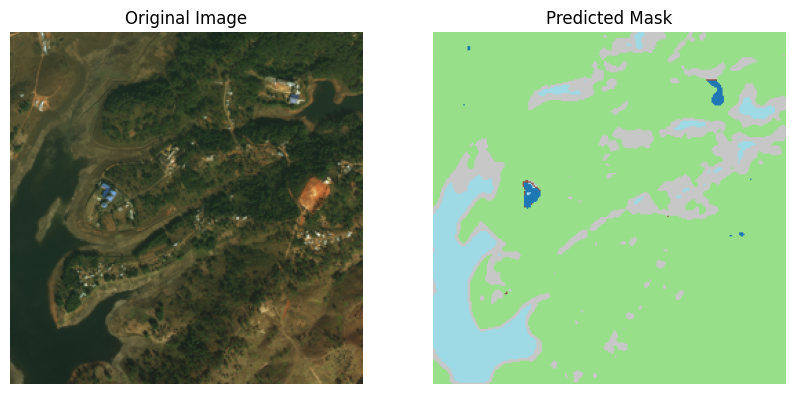

In [6]:
import glob
from PIL import Image
import numpy as np
import tensorflow as tf

# Path to your test images (change if needed)
test_images_dir = os.path.join(RAW_DATA_DIR, "test")
test_image_files = sorted(glob.glob(os.path.join(test_images_dir, "*.jpg")))

# Load a sample image
sample_image_path = test_image_files[0]
image = Image.open(sample_image_path).convert("RGB").resize((256, 256))
image = np.array(image) / 255.0
image = np.expand_dims(image, axis=0).astype(np.float32)  # Add batch dimension

# Predict
predicted_mask = loaded_model.predict(image)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tf.argmax(predicted_mask[0], axis=-1), cmap="tab20")
plt.title("Predicted Mask")
plt.axis('off')
plt.show()
